In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_5

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330803


## 1.5 Combining Different Particle Data

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

In [12]:
experiment = electrons + photons + pi0 + pi_char

In [13]:
# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

1592154


In [14]:
# split data into training and testing, next train XGBoost model
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
print(experiment.X_test.shape)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    # "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}


experiment.train_xgboost_model(params)

(318431, 22)
INFO: Trained XGBoost model; mean squared error: 3738.2218767895943


3738.2218767895943

In [15]:
utils.count_nodes(experiment.model)

36122

# Hyperparameter Scan in Search of Smaller Model

In cells below, tables represent models trained with different hyperparameters: number of rounds (trees), max depth, colsumple by tree and learnign rate.

In the end, best model with < 2000 nodes was the one with 130 trees, max depth of 4, colsample of 1.0 and a surprisingly high learning rate of 0.74 (although there was no strong dependency on this parameter, compared to for example no trees or depth). this miniutarised model has 1950 nodes in total.

In [16]:
max_depth_range = [6]
learning_rate_range = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
colsample_bytree_range = [0.6, 0.7, 0.8, 0.9, 1.0]
num_rounds_grid = [600]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams1 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 3805.651409674172
INFO: Trained XGBoost model; mean squared error: 3800.919482372775
INFO: Trained XGBoost model; mean squared error: 3810.347782934878
INFO: Trained XGBoost model; mean squared error: 3819.8010258082027
INFO: Trained XGBoost model; mean squared error: 3824.5391516838345
INFO: Trained XGBoost model; mean squared error: 3787.5494941759844
INFO: Trained XGBoost model; mean squared error: 3786.1747762887417
INFO: Trained XGBoost model; mean squared error: 3788.6445971514063
INFO: Trained XGBoost model; mean squared error: 3789.978971751842
INFO: Trained XGBoost model; mean squared error: 3806.629076891047
INFO: Trained XGBoost model; mean squared error: 3773.988137211797
INFO: Trained XGBoost model; mean squared error: 3775.677724789084
INFO: Trained XGBoost model; mean squared error: 3782.6304852826897
INFO: Trained XGBoost model; mean squared error: 3776.5570358626537
INFO: Trained XGBoost model; mean squared error: 3777.5

In [17]:
experiment_hyperparams1.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,colsample_bytree,n_estimators,Nodes NO
53,3724.100052,reg:squarederror,6,0.20,0.9,600,36219
52,3726.905456,reg:squarederror,6,0.20,0.8,600,36102
48,3727.008986,reg:squarederror,6,0.19,0.9,600,36205
47,3732.964234,reg:squarederror,6,0.19,0.8,600,36030
41,3734.319475,reg:squarederror,6,0.18,0.7,600,36404
43,3735.865784,reg:squarederror,6,0.18,0.9,600,36152
46,3736.094170,reg:squarederror,6,0.19,0.7,600,36322
38,3737.443997,reg:squarederror,6,0.17,0.9,600,36256
42,3738.221877,reg:squarederror,6,0.18,0.8,600,36122
51,3741.064349,reg:squarederror,6,0.20,0.7,600,36287


In [18]:
max_depth_range = [3, 4, 5, 6]
learning_rate_range = [0.18]
colsample_bytree_range = [0.8]
num_rounds_grid = [130, 150, 200, 300, 400, 500, 600]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams2 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 5613.799624024812
INFO: Trained XGBoost model; mean squared error: 5467.235884684345
INFO: Trained XGBoost model; mean squared error: 5214.880650514756
INFO: Trained XGBoost model; mean squared error: 4919.766141485433
INFO: Trained XGBoost model; mean squared error: 4772.512316164467
INFO: Trained XGBoost model; mean squared error: 4648.3120520695675
INFO: Trained XGBoost model; mean squared error: 4568.730825927251
INFO: Trained XGBoost model; mean squared error: 4848.719371251344
INFO: Trained XGBoost model; mean squared error: 4746.704771557914
INFO: Trained XGBoost model; mean squared error: 4566.995785572901
INFO: Trained XGBoost model; mean squared error: 4359.185332145799
INFO: Trained XGBoost model; mean squared error: 4253.204183259697
INFO: Trained XGBoost model; mean squared error: 4156.714139558624
INFO: Trained XGBoost model; mean squared error: 4086.1701687481077
INFO: Trained XGBoost model; mean squared error: 4466.166135

In [19]:
max_depth_range = [4]
learning_rate_range = [
    0.1,
    0.11,
    0.12,
    0.13,
    0.14,
    0.15,
    0.16,
    0.17,
    0.18,
    0.19,
    0.2,
    0.21,
    0.22,
    0.23,
    0.24,
    0.25,
    0.26,
    0.27,
    0.28,
    0.29,
    0.30,
    0.31,
    0.32,
    0.33,
    0.34,
    0.35,
    0.36,
    0.37,
    0.38,
    0.39,
    0.40,
    0.41,
    0.42,
    0.43,
    0.44,
    0.45,
    0.46,
    0.48,
    0.5,
    0.52,
    0.53,
    0.55,
    0.57,
    0.59,
    0.6,
    0.63,
    0.65,
    0.66,
    0.67,
    0.68,
    0.69,
    0.7,
    0.71,
    0.72,
    0.73,
    0.74,
    0.75,
    0.76,
    0.77,
    0.78,
    0.79,
    0.8,
    0.81,
    0.82,
    0.83,
    0.84,
    0.85,
]
colsample_bytree_range = [0.6, 0.7, 0.8, 0.9, 1.0]
num_rounds_grid = [130]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams3 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 5517.477298075122
INFO: Trained XGBoost model; mean squared error: 5384.593927886617
INFO: Trained XGBoost model; mean squared error: 5353.234583181072
INFO: Trained XGBoost model; mean squared error: 5382.806533247038
INFO: Trained XGBoost model; mean squared error: 5394.304450994713
INFO: Trained XGBoost model; mean squared error: 5419.191649719768
INFO: Trained XGBoost model; mean squared error: 5300.743768264235
INFO: Trained XGBoost model; mean squared error: 5264.792492359469
INFO: Trained XGBoost model; mean squared error: 5281.171765999631
INFO: Trained XGBoost model; mean squared error: 5266.231974793995
INFO: Trained XGBoost model; mean squared error: 5312.605296454409
INFO: Trained XGBoost model; mean squared error: 5217.524403578606
INFO: Trained XGBoost model; mean squared error: 5191.966172714764
INFO: Trained XGBoost model; mean squared error: 5200.299200250827
INFO: Trained XGBoost model; mean squared error: 5192.42237721

In [20]:
max_depth_range = [4, 5]
learning_rate_range = [0.74]
colsample_bytree_range = [1.0]
num_rounds_grid = [60, 65, 70, 75, 80, 85, 100, 130]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams4 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 4849.790419183056
INFO: Trained XGBoost model; mean squared error: 4804.845400109129
INFO: Trained XGBoost model; mean squared error: 4762.596682838802
INFO: Trained XGBoost model; mean squared error: 4716.0858578376465
INFO: Trained XGBoost model; mean squared error: 4697.071757484923
INFO: Trained XGBoost model; mean squared error: 4655.639429845194
INFO: Trained XGBoost model; mean squared error: 4561.122171439937
INFO: Trained XGBoost model; mean squared error: 4413.71731287218
INFO: Trained XGBoost model; mean squared error: 4610.511526903204
INFO: Trained XGBoost model; mean squared error: 4553.6442090886485
INFO: Trained XGBoost model; mean squared error: 4511.262845545603
INFO: Trained XGBoost model; mean squared error: 4470.8699567772865
INFO: Trained XGBoost model; mean squared error: 4445.890668416283
INFO: Trained XGBoost model; mean squared error: 4431.198348910913
INFO: Trained XGBoost model; mean squared error: 4349.689063

In [21]:
max_depth_range = [3, 4, 5, 6]
learning_rate_range = [0.74]
colsample_bytree_range = [1.0]
num_rounds_grid = [130, 150, 200, 275, 300, 600]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams5 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 4881.980724476632
INFO: Trained XGBoost model; mean squared error: 4771.6967802263935
INFO: Trained XGBoost model; mean squared error: 4593.657843960922
INFO: Trained XGBoost model; mean squared error: 4440.735029813768
INFO: Trained XGBoost model; mean squared error: 4410.518197602103
INFO: Trained XGBoost model; mean squared error: 4156.62156128738
INFO: Trained XGBoost model; mean squared error: 4413.71731287218
INFO: Trained XGBoost model; mean squared error: 4353.191860664022
INFO: Trained XGBoost model; mean squared error: 4245.764668568813
INFO: Trained XGBoost model; mean squared error: 4147.749232548263
INFO: Trained XGBoost model; mean squared error: 4115.128991780569
INFO: Trained XGBoost model; mean squared error: 3983.761694592407
INFO: Trained XGBoost model; mean squared error: 4254.570658018006
INFO: Trained XGBoost model; mean squared error: 4219.362666818107
INFO: Trained XGBoost model; mean squared error: 4152.934252656

In [28]:
experiment_hyperparams5.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,colsample_bytree,n_estimators,Nodes NO
11,3983.761695,reg:squarederror,4,0.74,1.0,600,8960
17,4035.320388,reg:squarederror,5,0.74,1.0,600,18295
16,4068.492008,reg:squarederror,5,0.74,1.0,300,9206
15,4076.151214,reg:squarederror,5,0.74,1.0,275,8444
10,4115.128992,reg:squarederror,4,0.74,1.0,300,4497
21,4122.389198,reg:squarederror,6,0.74,1.0,275,16703
22,4125.836296,reg:squarederror,6,0.74,1.0,300,18217
20,4141.062327,reg:squarederror,6,0.74,1.0,200,12228
9,4147.749233,reg:squarederror,4,0.74,1.0,275,4123
14,4152.934253,reg:squarederror,5,0.74,1.0,200,6141


In [69]:
# train miniaturised model
print(experiment.X_test.shape)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "learning_rate": 0.74,
    "gamma": 6,  # min split loss
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "n_estimators": 130,
}


experiment.train_xgboost_model(params)

(318431, 22)
INFO: Trained XGBoost model; mean squared error: 4403.98895287476


4403.98895287476

In [70]:
utils.count_nodes(experiment.model)

1920

In [71]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

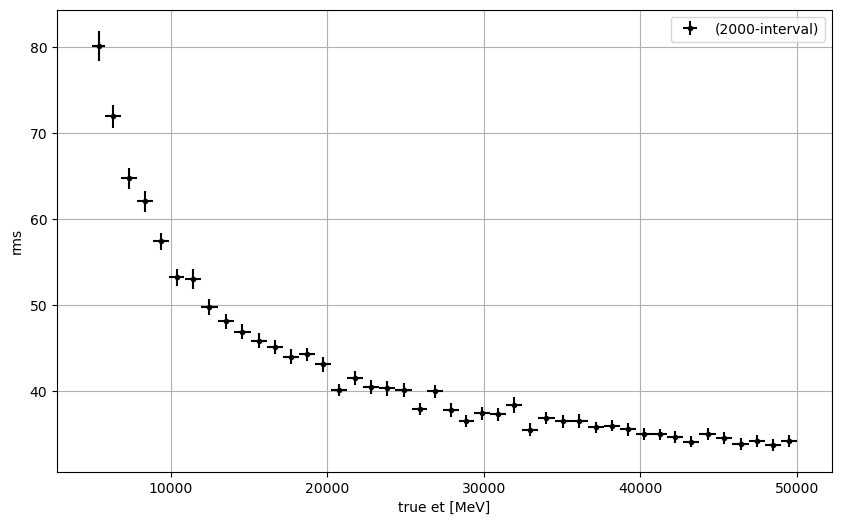

In [74]:
x_e, y_e, x_u_e, u_e = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

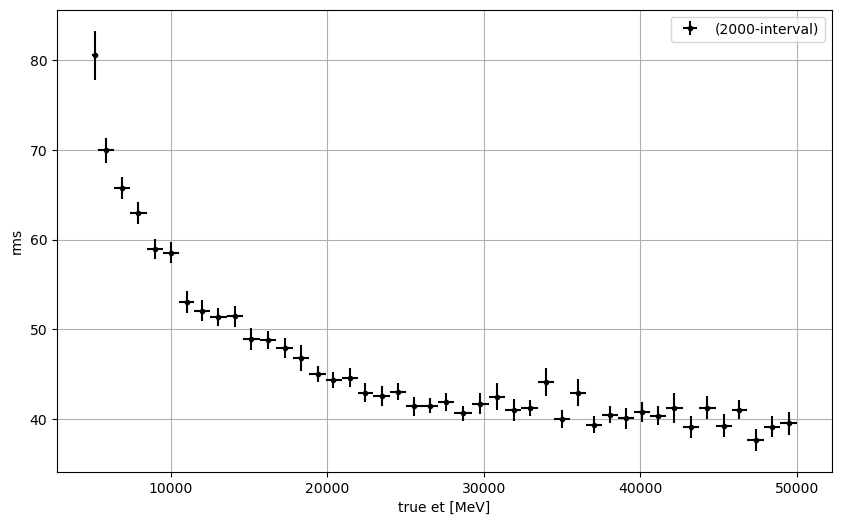

In [75]:
x_p, y_p, x_u_p, u_p = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

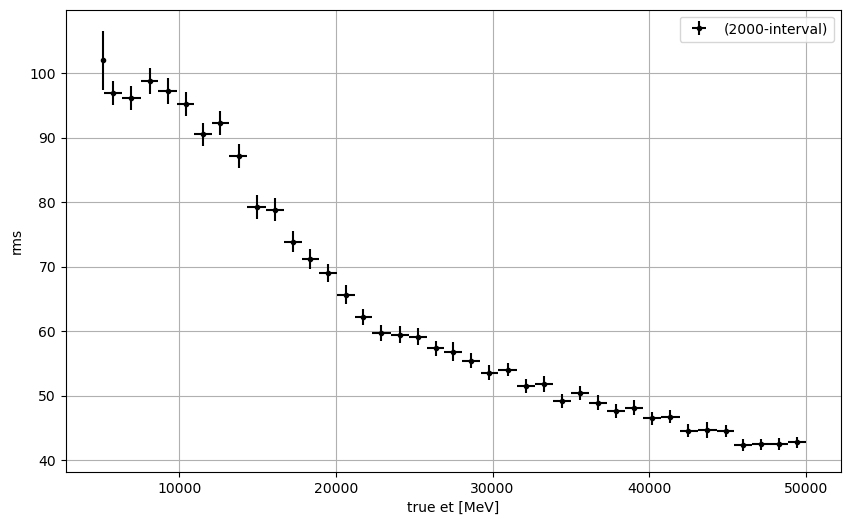

In [76]:
x_pi0, y_pi0, x_u_pi0, u_pi0 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

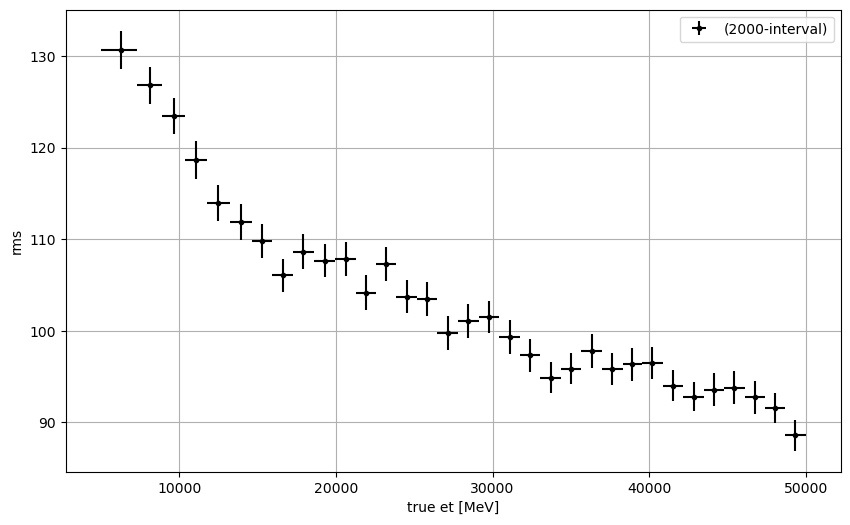

In [77]:
x_pi_char, y_pi_char, x_u_pi_char, u_pi_char = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

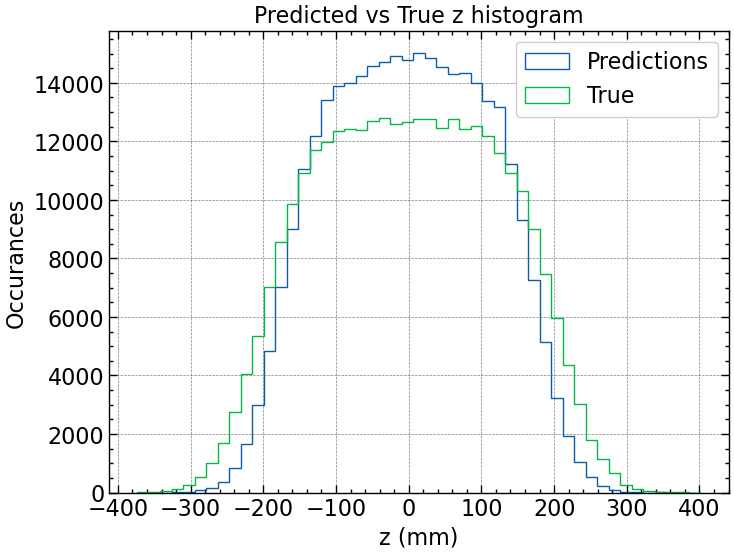

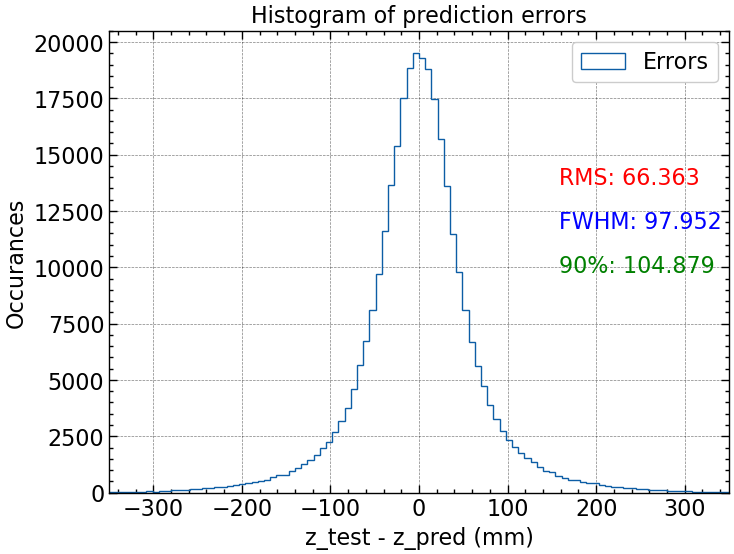

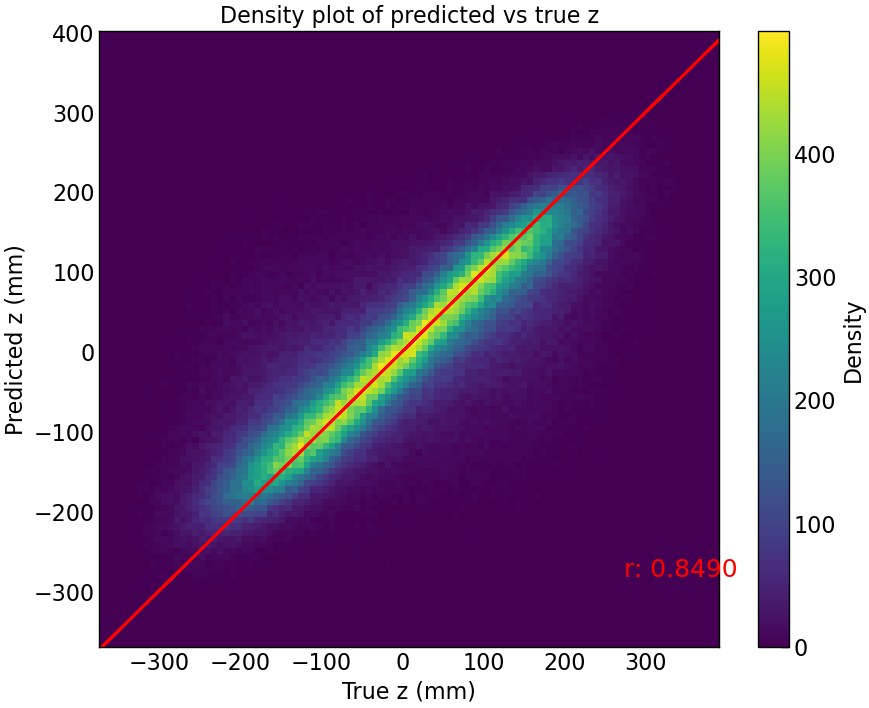

In [78]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=False, plot_line=True)